## RandomForestRegressor

In [282]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import re

# Load datasets
df_listings = pd.read_csv('hemnet_listings.csv')
df_sold = pd.read_csv('hemnet_sold_listings.csv')

# For df_sold: Drop rows where 'exact_address' or 'listing_price' is missing
df_sold = df_sold.dropna(subset=['exact_address', 'listing_price', 'size'])
df_listings = df_listings.dropna(subset=['exact_address', 'price', 'size'])
df_sold = df_sold[df_sold['exact_address'].str.strip() != '']
df_listings = df_listings[df_listings['exact_address'].str.strip() != '']

# Generate random dates for df_listings
current_date = datetime.now()
one_month_ago = current_date - timedelta(days=30)
df_listings['date'] = pd.to_datetime([one_month_ago + timedelta(days=np.random.randint(0, 31)) for _ in range(len(df_listings))])

# Parse location function (keep this as is)
def parse_location_enhanced(location_str):
    if isinstance(location_str, str):
        location_str = location_str.strip().lower()
        location_str = re.sub(r',?\s*stockholms kommun', '', location_str)
        split_regex = r'[-/|]'
        parts = re.split(split_regex, location_str)
        main_neighborhood = parts[0].strip()
        sub_neighborhood = parts[1].strip() if len(parts) > 1 else 'central'
        return main_neighborhood, sub_neighborhood
    else:
        return 'unknown', 'unknown'

# Apply location parsing
df_sold['main_neighborhood'], df_sold['sub_neighborhood'] = zip(*df_sold['location'].apply(parse_location_enhanced))
df_listings['main_neighborhood'], df_listings['sub_neighborhood'] = zip(*df_listings['location'].apply(parse_location_enhanced))

# Convert date columns
df_sold['date'] = pd.to_datetime(df_sold['date'])

# Add date features
for df in [df_sold, df_listings]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['season'] = df['date'].dt.month % 12 // 3 + 1

# Feature engineering
for df in [df_sold, df_listings]:
    df['rooms_per_sqm'] = df['rooms'] / df['size']
    df['is_central'] = df['location'].str.contains('centrum|centrala|city', case=False, na=False).astype(int)
    df['price_per_sqm'] = df['listing_price' if 'listing_price' in df.columns else 'price'] / df['size']

# Remove 'location' column as it's been parsed
df_sold = df_sold.drop('location', axis=1)
df_listings = df_listings.drop('location', axis=1)

# Calculate seasonal price trends (average price per sqm per season)
seasonal_price_trend_sold = df_sold.groupby('season')['price_per_sqm'].mean()
df_sold['seasonal_price_trend'] = df_sold['season'].map(seasonal_price_trend_sold)
df_listings['seasonal_price_trend'] = df_listings['season'].map(seasonal_price_trend_sold)

# Calculate historical price trends for neighborhoods (based on price per sqm)
df_sold['price_change_pct'] = df_sold.groupby('main_neighborhood')['price_per_sqm'].pct_change().fillna(0)
df_listings['price_change_pct'] = df_listings['main_neighborhood'].map(df_sold.groupby('main_neighborhood')['price_per_sqm'].pct_change().fillna(0))

# Calculate the average monthly price change (based on price per sqm)
df_sold['monthly_price_change'] = df_sold.groupby('month')['price_per_sqm'].pct_change().fillna(0)
df_listings['monthly_price_change'] = df_listings['month'].map(df_sold.groupby('month')['price_per_sqm'].pct_change().fillna(0))

# Calculate average price per square meter for neighborhoods
location_avg_price_sold = df_sold.groupby('main_neighborhood')['price_per_sqm'].mean()
df_sold['location_avg_price_per_sqm'] = df_sold['main_neighborhood'].map(location_avg_price_sold)
df_listings['location_avg_price_per_sqm'] = df_listings['main_neighborhood'].map(location_avg_price_sold)

location_avg_price_sold_sub = df_sold.groupby('sub_neighborhood')['price_per_sqm'].mean()
df_sold['location_avg_price_per_sqm_sub'] = df_sold['sub_neighborhood'].map(location_avg_price_sold_sub)
df_listings['location_avg_price_per_sqm_sub'] = df_listings['sub_neighborhood'].map(location_avg_price_sold_sub)

# Calculate months since sale for sold properties
current_date = datetime.now()
df_sold['months_since_sale'] = (current_date - df_sold['date']).dt.days / 30.44  # average days in a month

# For listings, calculate months since listing
df_listings['months_since_sale'] = (current_date - df_listings['date']).dt.days / 30.44

# Replace inf and -inf values with NaN
df_sold.replace([np.inf, -np.inf], np.nan, inplace=True)
df_listings.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the consistent feature set for both datasets
features = ['size', 'rooms', 'monthly_fee', 'has_elevator', 'has_balcony',
            'rooms_per_sqm', 'is_central', 'location_avg_price_per_sqm', 'location_avg_price_per_sqm_sub',
            'year', 'month', 'season', 'main_neighborhood', 'sub_neighborhood', 'months_since_sale',
            'seasonal_price_trend', 'price_change_pct', 'monthly_price_change', 'price_per_sqm']

# Prepare pipeline
numeric_features = ['size', 'rooms', 'monthly_fee', 'rooms_per_sqm', 'location_avg_price_per_sqm', 'location_avg_price_per_sqm_sub', 'year', 'seasonal_price_trend', 'price_change_pct', 'monthly_price_change', 'months_since_sale', 'price_per_sqm']
categorical_features = ['has_elevator', 'has_balcony', 'main_neighborhood', 'sub_neighborhood', 'is_central', 'month', 'season']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ])

# Create RandomForestRegressor pipeline
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Prepare the data for training
X_sold = df_sold[features]
y_sold = df_sold['listing_price']  # Now training on listing_price

# Remove outliers function
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

X_sold = remove_outliers(X_sold, numeric_features)
y_sold = y_sold.loc[X_sold.index]

# Perform randomized search for hyperparameter tuning
param_distributions = {
    'regressor__n_estimators': [100, 500, 1000],
    'regressor__max_depth': [None, 10, 30, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': [None, 'sqrt', 'log2']
}
random_search = RandomizedSearchCV(rf_model, param_distributions, n_iter=10, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, random_state=42)
random_search.fit(X_sold, y_sold)

# Predict prices for the listings
X_listings = df_listings[features]
y_pred_listings = random_search.predict(X_listings)
df_listings['predicted_price'] = y_pred_listings

# Save the results
df_listings.to_csv('predicted_prices_for_listings.csv', index=False)

# Evaluate the model performance
y_pred_sold = random_search.predict(X_sold)
rmse = np.sqrt(mean_squared_error(y_sold, y_pred_sold))
r2 = r2_score(y_sold, y_pred_sold)
mape_score = mean_absolute_percentage_error(y_sold, y_pred_sold) * 100

print("\nRandom Forest Model Performance on Training Data:")
print(f"Root mean squared error: {rmse}")
print(f"R-squared score: {r2}")
print(f"Mean Absolute Percentage Error: {mape_score:.2f}%")

# Print best hyperparameters
print(f"\nBest hyperparameters: {random_search.best_params_}")

# Print feature importances
rf_feature_importances = random_search.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = (numeric_features + 
                 random_search.best_estimator_
                     .named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())

importance_df = pd.DataFrame({'feature': feature_names, 'importance': rf_feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(importance_df.head(15))  # Print top 15 features


Random Forest Model Performance on Training Data:
Root mean squared error: 101182.6038625289
R-squared score: 0.9983384025442336
Mean Absolute Percentage Error: 1.21%

Best hyperparameters: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': None, 'regressor__max_depth': None}

Random Forest Feature Importances:
                         feature  importance
0                           size    0.532273
11                 price_per_sqm    0.441273
4     location_avg_price_per_sqm    0.018736
1                          rooms    0.001552
2                    monthly_fee    0.001250
3                  rooms_per_sqm    0.001109
8               price_change_pct    0.000983
196  main_neighborhood_östermalm    0.000927
9           monthly_price_change    0.000826
10             months_since_sale    0.000515
14             has_balcony_False    0.000083
15              has_balcony_True    0.000081
205                    

In [261]:
def calculate_price_delta(row):
    actual = row['price']
    predicted = row['predicted_price']
    
    if actual == predicted:
        return 0
    elif actual == 0:
        return np.inf if predicted > 0 else -np.inf
    else:
        return (predicted - actual) / abs(actual) * 100

df_listings['price_delta'] = df_listings.apply(calculate_price_delta, axis=1)

### Visualizations

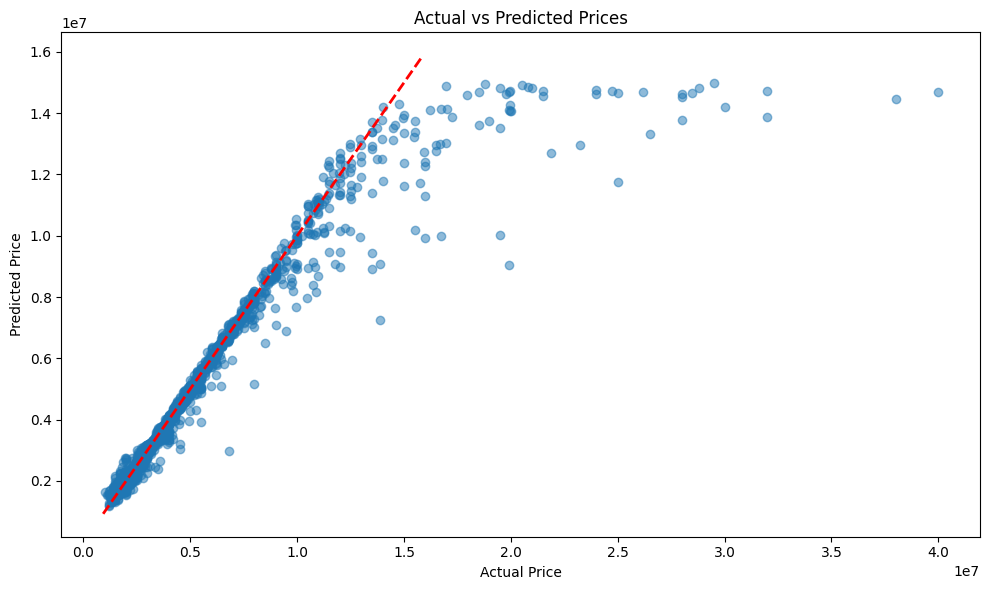

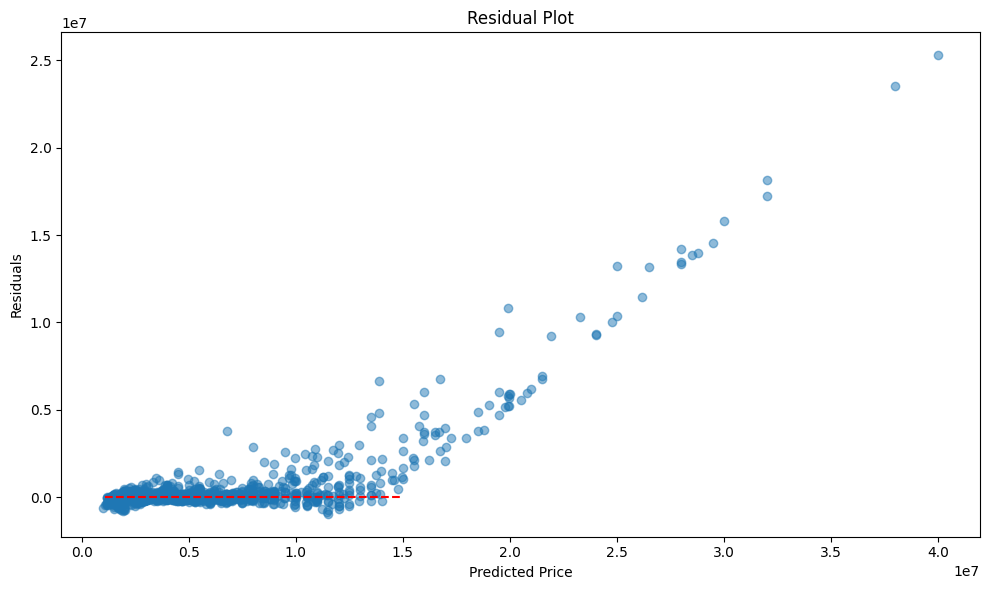

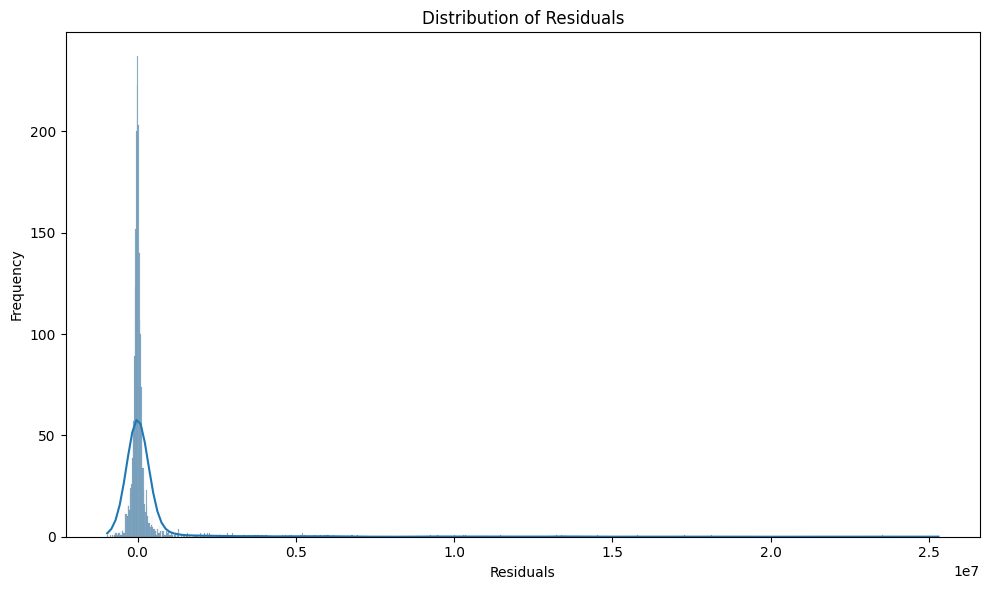

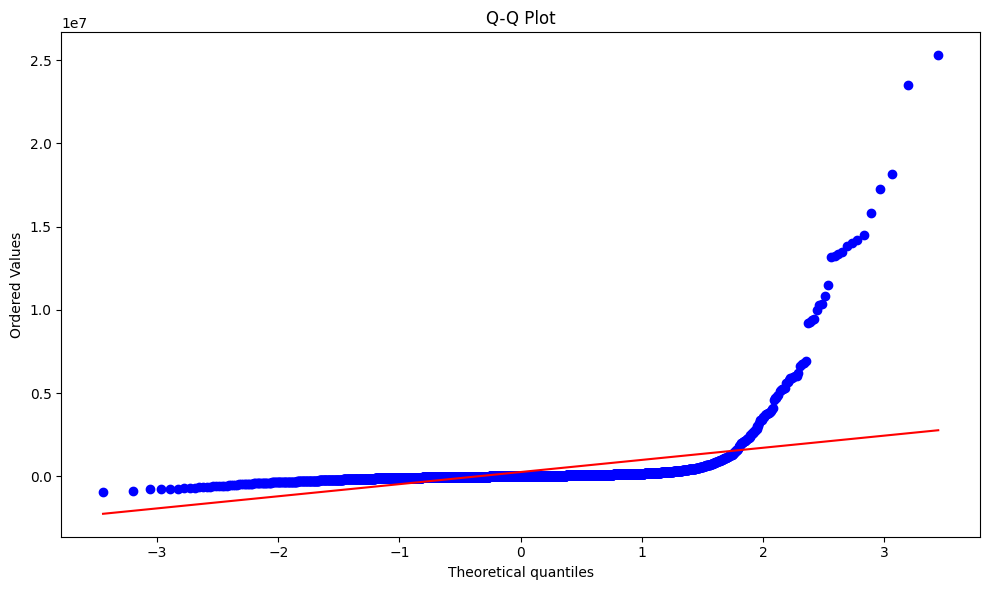

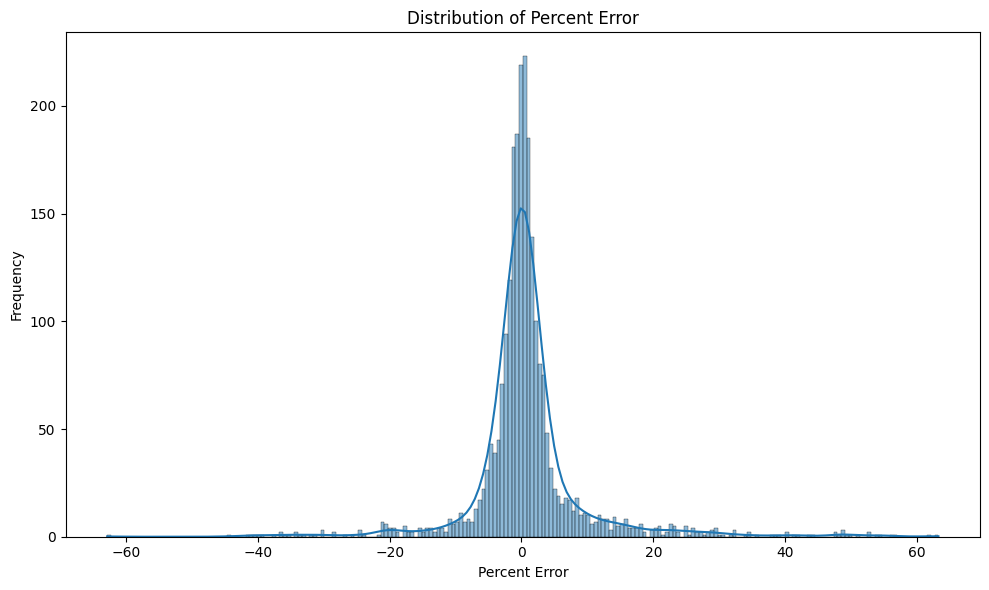

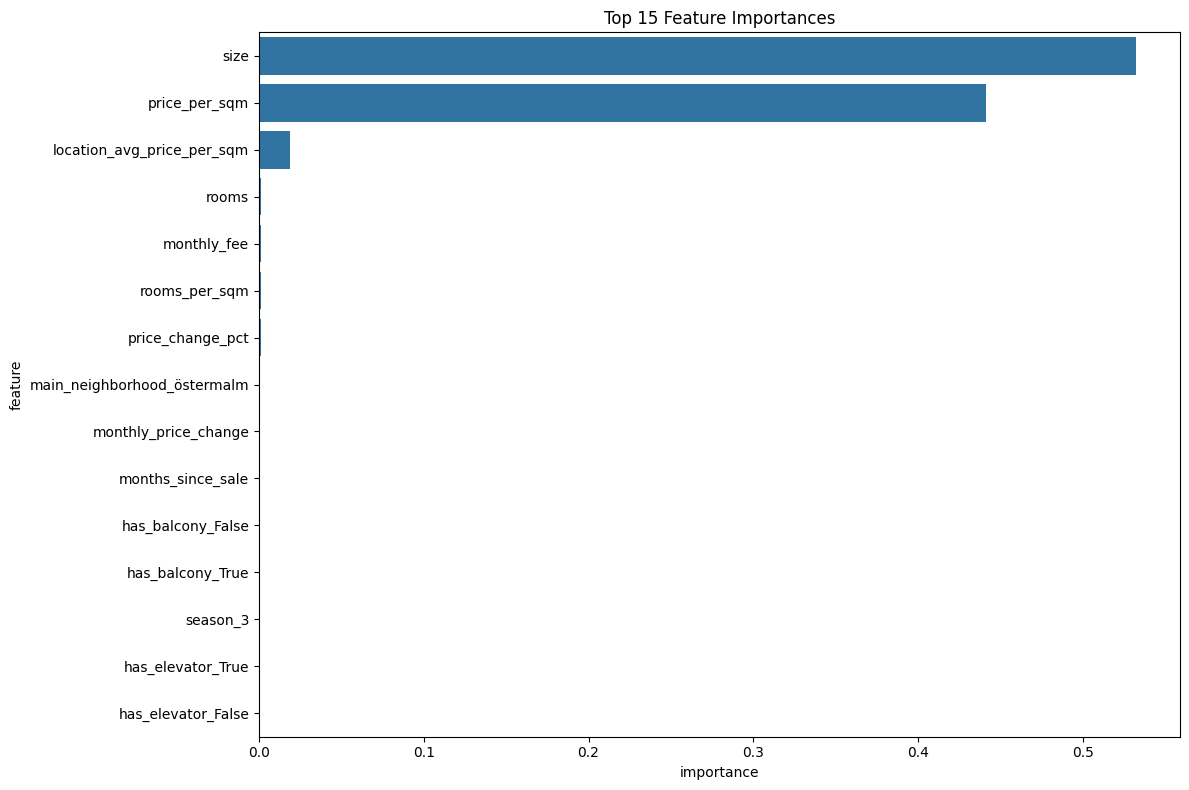

Visualization plots have been saved as PNG files.

Additional Metrics:
Mean Squared Error (MSE): 2350588554725.76
Root Mean Squared Error (RMSE): 1533162.93
Mean Absolute Error (MAE): 352771.69
R-squared (R2) Score: 0.84
Mean Absolute Percentage Error (MAPE): 1.21%


In [267]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# Assuming y_sold and y_pred_sold are already defined from your previous code

y_listings = df_listings[target]
y_pred_listings

# 1. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_listings, y_pred_listings, alpha=0.5)
plt.plot([y_sold.min(), y_sold.max()], [y_sold.min(), y_sold.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_listings - y_pred_listings
plt.figure(figsize=(10, 6))
plt.scatter(y_listings, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_sold.min(), xmax=y_pred_sold.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# 3. Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

# 4. Q-Q Plot
from scipy import stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.tight_layout()
plt.show()

# 5. Prediction Error Distribution
percent_error = (residuals / y_listings) * 100
plt.figure(figsize=(10, 6))
sns.histplot(percent_error, kde=True)
plt.xlabel('Percent Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Error')
plt.tight_layout()
plt.show()

# 6. Feature Importance Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

print("Visualization plots have been saved as PNG files.")

# Calculate and print additional metrics
mse = mean_squared_error(y_listings, y_pred_listings)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
r2 = r2_score(y_listings, y_pred_listings)

print(f"\nAdditional Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_score:.2f}%")

## Neural Network

In [378]:
df_listings

link  \
0                                https://www.hemnet.se/bostad/lagenhet-4rum-vasastan-stockholms-kommun-gavlegatan-4,-2-1-2-tr-21408668   
1                         https://www.hemnet.se/bostad/lagenhet-1,5rum-gardet-ostermalm-stockholms-kommun-osthammarsgatan-70b-21410680   
3                                      https://www.hemnet.se/bostad/lagenhet-3rum-mariehall-stockholms-kommun-masugnsvagen-86-20548297   
4     https://www.hemnet.se/bostad/lagenhet-2rum-spanga-bromstensstaden-stockholms-kommun-akare-engstroms-vag-5,-2-tr-lgh-065-21274981   
5                                      https://www.hemnet.se/bostad/lagenhet-3rum-gardet-stockholms-kommun-sandhamnsgatan-75b-21286901   
...                                                                                                                                ...   
2443                                 https://www.hemnet.se/bostad/lagenhet-2rum-vasastan-stockholms-kommun-kungstensgatan-35a-21384689   
2444                             https://www.hemnet.se/bostad/lagenhet-2rum-vasastan-hagastaden-stockholms-kommun-torsplan-10-21336802   
2445                                    https://www.hemnet.se/bostad/lagenhet-2rum-kista-stockholms-kommun-helsingorsgatan-42-21384579   
2446                                      https://www.hemnet.se/bostad/lagenhet-4rum-satra-stockholms-kommun-eksatravagen-414-21384924   
2447                       https://www.hemnet.se/bostad/lagenhet-3rum-bredang-skarholmen-stockholms-kommun-odd-fellowvagen-21-21353376   

              exact_address  listing_price  size  rooms  floor  monthly_fee  \
0              Gävlegatan 4       10500000  96.0    4.0      3       4561.0   
1       Östhammarsgatan 70B        3250000  35.0    1.5      2       2610.0   
3           Masugnsvägen 86        5795000  79.5    3.0      3       4797.0   
4     Åkare Engströms Väg 5        2150000  43.0    2.0      3       2662.0   
5        Sandhamnsgatan 75B        7395000  82.0    3.0      1       6186.0   
...                     ...            ...   ...    ...    ...          ...   
2443     Kungstensgatan 35A        7895000  68.0    2.0      3       4099.0   
2444            Torsplan 10        6450000  51.0    2.0     13       4941.0   
2445     Helsingörsgatan 42        1795000  47.5    2.0      4       4588.0   
2446       Eksätravägen 414        3200000  99.0    4.0      1       6843.0   
2447     Odd fellowvägen 21        2975000  74.0    3.0      1       5042.0   

      price_per_sqm                                      location  \
0     109375.000000                   Vasastan, Stockholms kommun   
1      92857.142857         Gärdet - Östermalm, Stockholms kommun   
3      72893.081761                  Mariehäll, Stockholms kommun   
4      50000.000000  Spånga  - Bromstensstaden, Stockholms kommun   
5      90182.926829                     Gärdet, Stockholms kommun   
...             ...                                           ...   
2443  116102.941176                   Vasastan, Stockholms kommun   
2444  126470.588235      Vasastan - Hagastaden, Stockholms kommun   
2445   37789.473684                      Kista, Stockholms kommun   
2446   32323.232323                      Sätra, Stockholms kommun   
2447   40202.702703         Bredäng-Skärholmen, Stockholms kommun   

      has_elevator  ...  season  rooms_per_sqm  is_central months_since_sale  \
0             True  ...       3       0.041667           0          0.985545   
1             True  ...       3       0.042857           0          0.788436   
3             True  ...       4       0.037736           0          0.394218   
4             True  ...       4       0.046512           0          0.065703   
5             True  ...       3       0.036585           0          0.886991   
...            ...  ...     ...            ...         ...               ...   
2443         False  ...       3       0.029412           0          0.722733   
2444          True  ...       4       0.039216         

In [379]:
df_sold = pd.read_csv('hemnet_sold_listings.csv')
df_sold.columns

Index(['link', 'exact_address', 'size', 'rooms', 'monthly_fee', 'location',
       'has_elevator', 'has_balcony', 'listing_price', 'end_price',
       'price_change_percentage', 'price_per_sqm', 'date'],
      dtype='object')

Original dataset size: (2307, 27)
Balanced dataset size: (2312, 27)
Number of features after preprocessing: 334
Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5005 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3383 - val_loss: 0.3338 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1875 - val_loss: 0.3569 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1181 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0946 - val_loss: 0.3532 - learning_rate: 0.0010
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0908 - val_loss: 0.3569 - learning_rate: 0.0010
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0779 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0650 - val_loss: 0.3376 - learning_rate: 0.0010
Epoch 9/

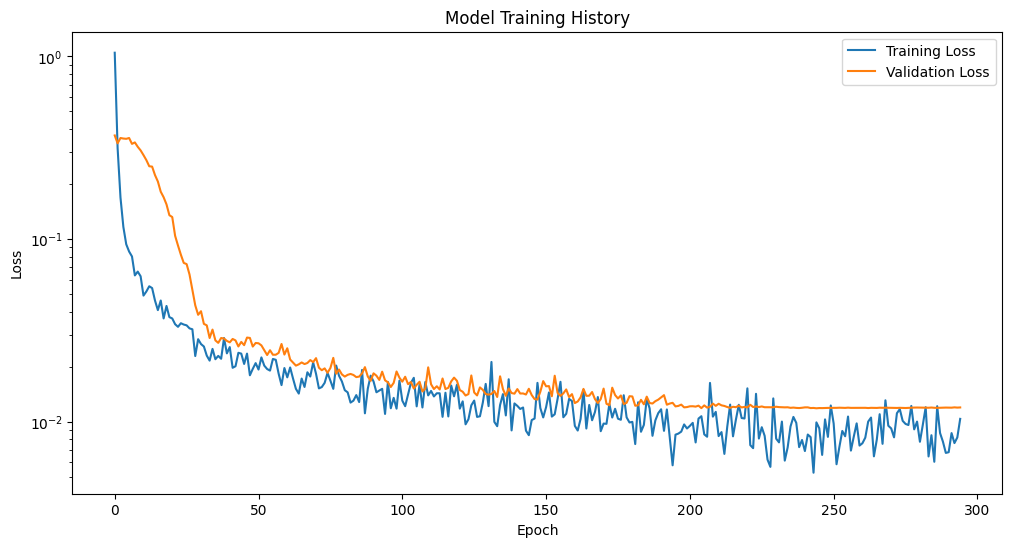

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Neural Network Performance:
Root Mean Squared Error (RMSE): 367439.91
R-squared Score: 0.9760
Mean Absolute Percentage Error (MAPE): 5.47%
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step

Price Delta Summary Statistics:
count    2366.000000
mean        6.940194
std        10.817920
min       -80.113008
25%         1.212750
50%         6.805881
75%        12.001197
max        71.667608
Name: price_delta, dtype: float64

Percentage Difference In Predictions: 9.58%


In [398]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ===========================
# 1. Load Datasets
# ===========================

df_listings = pd.read_csv('hemnet_listings.csv')
df_sold = pd.read_csv('hemnet_sold_listings.csv')

# ===========================
# 2. Data Cleaning and Preprocessing
# ===========================

def clean_data(df, price_column='price'):
    """
    Cleans the dataset by dropping rows with missing values in critical columns
    and removing entries with empty 'exact_address'.
    """
    df = df.dropna(subset=['exact_address', price_column, 'size'])
    df = df[df['exact_address'].str.strip() != '']
    return df

# Adjust columns:
# In df_sold, 'end_price' is the actual sale price. We'll create 'price' from 'end_price'.
df_sold['price'] = df_sold['end_price']

# In df_listings, 'price' is the listing price. Rename it to 'listing_price' for clarity.
df_listings = df_listings.rename(columns={'price': 'listing_price'})

# Now clean the data using the standardized 'price' column in df_sold and 'listing_price' in df_listings
df_sold = clean_data(df_sold, price_column='price')
df_listings = clean_data(df_listings, price_column='listing_price')

# ===========================
# 3. Generate Random Dates for Listings
# ===========================

current_date = datetime.now()
one_month_ago = current_date - timedelta(days=30)
df_listings['date'] = pd.to_datetime([
    one_month_ago + timedelta(days=np.random.randint(0, 31)) for _ in range(len(df_listings))
])

# ===========================
# 4. Parse Location
# ===========================

def parse_location_enhanced(location_str):
    """
    Parses the location string to extract main and sub neighborhoods.
    """
    if isinstance(location_str, str):
        location_str = location_str.strip().lower()  # Use .lower() instead of .toLowerCase()
        location_str = re.sub(r',?\s*stockholms kommun', '', location_str)
        split_regex = r'[-/|]'
        parts = re.split(split_regex, location_str)
        main_neighborhood = parts[0].strip()
        sub_neighborhood = parts[1].strip() if len(parts) > 1 else 'central'
        return main_neighborhood, sub_neighborhood
    else:
        return 'unknown', 'unknown'


# Apply location parsing to both datasets
for df in [df_sold, df_listings]:
    df['main_neighborhood'], df['sub_neighborhood'] = zip(*df['location'].apply(parse_location_enhanced))

# Convert 'date' columns to datetime in df_sold
df_sold['date'] = pd.to_datetime(df_sold['date'])

# ===========================
# 5. Feature Engineering
# ===========================

# Feature engineering function that preserves the 'date' column
def feature_engineering(df, price_col='listing_price'):
    """
    Creates new features to enhance model performance. This ensures that 'price_per_sqm' is calculated
    using only the listing price, not the end price.
    """
    # Keep 'date' in the DataFrame
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['season'] = df['date'].dt.month % 12 // 3 + 1
    df['rooms_per_sqm'] = df['rooms'] / df['size']
    df['is_central'] = df['location'].str.contains('centrum|centrala|city', case=False, na=False).astype(int)
    
    # Calculate 'price_per_sqm' based on listing price (not the end price to prevent leakage)
    df['price_per_sqm'] = df[price_col] / df['size']
    
    # Calculate 'months_since_sale' using 'date'
    df['months_since_sale'] = (current_date - df['date']).dt.days / 30.44

    # Log transformations to reduce skewness
    for col in ['size', 'price_per_sqm', 'monthly_fee']:
        if col in df.columns and (df[col] > 0).all():
            df[f'log_{col}'] = np.log1p(df[col])
        else:
            # Handle non-positive or missing values gracefully
            df[f'log_{col}'] = 0

    return df

# Apply feature engineering to both sold and listings datasets, while preserving 'date'
df_sold = feature_engineering(df_sold, price_col='price')
df_listings = feature_engineering(df_listings, price_col='listing_price')

# Apply feature engineering to both sold and listings datasets, using listing_price
df_sold = feature_engineering(df_sold, price_col='listing_price')
df_listings = feature_engineering(df_listings, price_col='listing_price')

# ===========================
# 6. Calculate Average Prices
# ===========================

def calculate_average_prices(df_sold, df_listings):
    """
    Calculates average price per sqm for main and sub neighborhoods
    and maps them back to the datasets.
    """
    location_avg_price = df_sold.groupby('main_neighborhood')['price_per_sqm'].mean()
    df_sold['location_avg_price_per_sqm'] = df_sold['main_neighborhood'].map(location_avg_price)
    df_listings['location_avg_price_per_sqm'] = df_listings['main_neighborhood'].map(location_avg_price)

    location_avg_price_sub = df_sold.groupby('sub_neighborhood')['price_per_sqm'].mean()
    df_sold['location_avg_price_per_sqm_sub'] = df_sold['sub_neighborhood'].map(location_avg_price_sub)
    df_listings['location_avg_price_per_sqm_sub'] = df_listings['sub_neighborhood'].map(location_avg_price_sub)

    return df_sold, df_listings

df_sold, df_listings = calculate_average_prices(df_sold, df_listings)

# ===========================
# 7. Handle Outliers
# ===========================

def remove_outliers(df, n_std=3):
    """
    Removes outliers from specified numerical columns based on the number of standard deviations.
    """
    columns = ['size', 'rooms', 'monthly_fee', 'price_per_sqm', 'price']

    for col in columns:
        if col in df.columns:
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - n_std * std
            upper_bound = mean + n_std * std
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply outlier removal to both datasets
df_sold = remove_outliers(df_sold)
df_listings = remove_outliers(df_listings)

# ===========================
# 8. Define Features
# ===========================

# Define the feature columns
features = [
    'size', 'rooms', 'monthly_fee', 'has_elevator', 'has_balcony',
    'listing_price',  # Ensure 'listing_price' is included as a feature
    'rooms_per_sqm', 'is_central', 'location_avg_price_per_sqm', 'location_avg_price_per_sqm_sub',
    'year', 'month', 'season', 'main_neighborhood', 'sub_neighborhood', 'months_since_sale',
    'price_per_sqm', 'log_size', 'log_price_per_sqm', 'log_monthly_fee'
]

# Define numerical and categorical features
numeric_features = [
    'size', 'rooms', 'monthly_fee', 'listing_price',
    'rooms_per_sqm', 'price_per_sqm', 'months_since_sale',
    'log_size', 'log_price_per_sqm', 'log_monthly_fee'
]
categorical_features = [
    'has_elevator', 'has_balcony', 'is_central', 
    'main_neighborhood', 'sub_neighborhood', 
    'month', 'season'
]

# ===========================
# 9. Data Resampling (Optional)
# ===========================

# To balance the dataset by oversampling low-value properties
# Define a threshold for low-value properties (e.g., below 5th percentile of sale prices)

threshold = df_sold['listing_price'].quantile(0.10)

# Separate majority and minority classes
df_low = df_sold[df_sold['listing_price'] < threshold]
df_high = df_sold[df_sold['listing_price'] >= threshold]

# Oversample minority class (low-value properties) to match the majority class
df_low_upsampled = resample(
    df_low, 
    replace=True,                     # sample with replacement
    n_samples=len(df_high),           # to match majority class
    random_state=42                   # reproducible results
)

# Combine majority class with upsampled minority class
df_sold_balanced = pd.concat([df_high, df_low_upsampled])

print("Original dataset size:", df_sold.shape)
print("Balanced dataset size:", df_sold_balanced.shape)

# Use the balanced dataset for training
df_sold = df_sold_balanced

# ===========================
# 10. Prepare Data for Training
# ===========================

# Features and target variable
X = df_sold[features]
y = df_sold['price']  # Actual sale price as target

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===========================
# 11. Create the Preprocessor
# ===========================

# Define the preprocessor with separate pipelines for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())  # RobustScaler handles outliers better
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ]
)

# Fit the preprocessor on the training data and transform both training and validation data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

print("Number of features after preprocessing:", X_train_preprocessed.shape[1])

# ===========================
# 12. Scale the Target Variable
# ===========================

# Scale the target variable using RobustScaler to reduce the influence of outliers
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

# ===========================
# 13. Create the Neural Network Model
# ===========================

def create_model(input_dim):
    """
    Creates and compiles the neural network model.
    """
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.01),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.01),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initialize the model with the correct input dimension
n_features = X_train_preprocessed.shape[1]
nn_model = create_model(n_features)

# ===========================
# 14. Define Callbacks
# ===========================

early_stopping = EarlyStopping(
    patience=50, 
    restore_best_weights=True, 
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    factor=0.2, 
    patience=20, 
    min_lr=0.00001, 
    verbose=1
)

# ===========================
# 15. Train the Model
# ===========================

history = nn_model.fit(
    X_train_preprocessed, y_train_scaled,
    validation_data=(X_val_preprocessed, y_val_scaled),
    epochs=1000,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ===========================
# 16. Inspect Preprocessed Data
# ===========================

print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train_scaled shape:", y_train_scaled.shape)

# ===========================
# 17. Training Results
# ===========================

# After training
final_epoch = len(history.history['loss'])
print(f"Final training loss after {final_epoch} epochs:", history.history['loss'][-1])
print(f"Final validation loss after {final_epoch} epochs:", history.history['val_loss'][-1])

# ===========================
# 18. Plot Training History
# ===========================

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Log scale for better visualization
plt.show()

# ===========================
# 19. Make Predictions on Validation Set
# ===========================

y_val_pred_scaled = nn_model.predict(X_val_preprocessed).flatten()

# Inverse transform the predictions and true values to original scale
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_val_true = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()

# ===========================
# 20. Evaluate the Model
# ===========================

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluates the model using RMSE, R-squared, and MAPE metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

evaluate_model(y_val_true, y_val_pred, "Neural Network")

# ===========================
# 21. Make Predictions for All Listings
# ===========================

# Prepare listings data
X_listings = df_listings[features]
X_listings_preprocessed = preprocessor.transform(X_listings)

# Predict using the trained model
listings_pred_scaled = nn_model.predict(X_listings_preprocessed).flatten()
listings_pred = y_scaler.inverse_transform(listings_pred_scaled.reshape(-1, 1)).flatten()

# Add predictions to df_listings
df_listings['predicted_price'] = listings_pred

# ===========================
# 22. Calculate Price Delta
# ===========================

def calculate_price_delta(row):
    """
    Calculates the percentage difference between predicted sale price and listing price.
    """
    actual = row['listing_price']
    predicted = row['predicted_price']
    if actual == 0:
        return np.inf if predicted > 0 else -np.inf
    else:
        return (predicted - actual) / abs(actual) * 100

df_listings['price_delta'] = df_listings.apply(calculate_price_delta, axis=1)

# ===========================
# 23. Summary Statistics
# ===========================

print("\nPrice Delta Summary Statistics:")
print(df_listings['price_delta'].describe())

# Handle infinite values by removing them from the calculation
mape = np.mean(np.abs(df_listings['price_delta'].replace([np.inf, -np.inf], np.nan).dropna()))
print(f"\nPercentage Difference In Predictions: {mape:.2f}%")

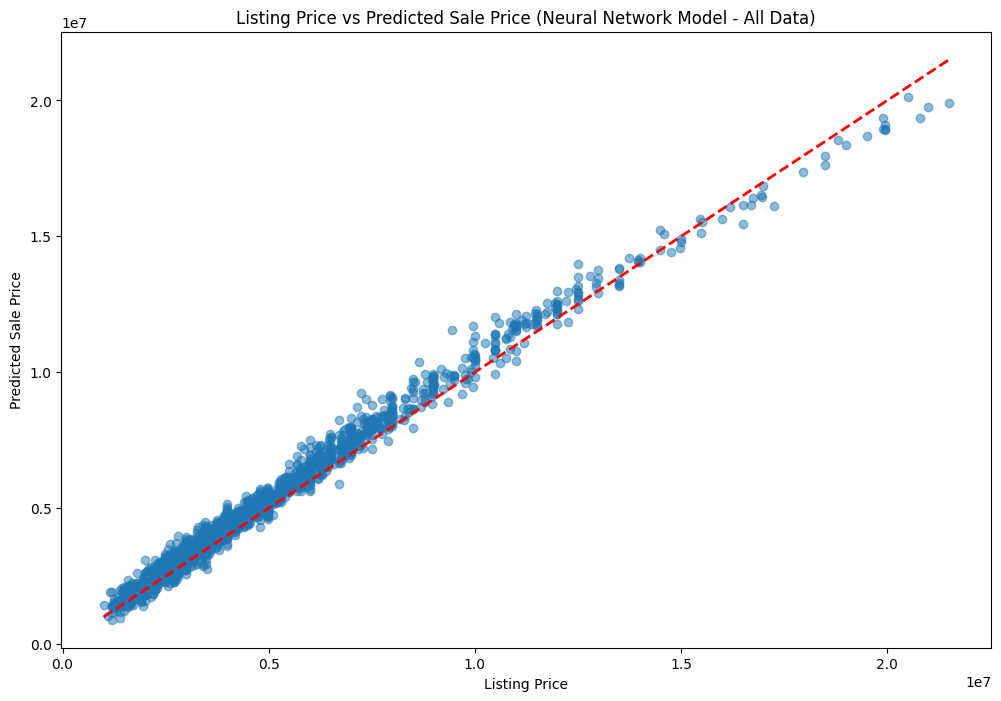

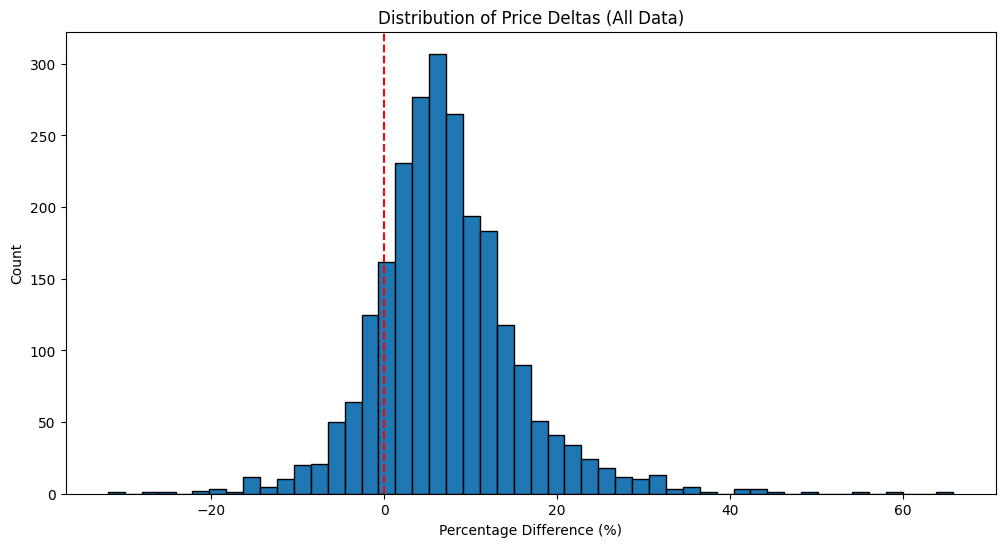

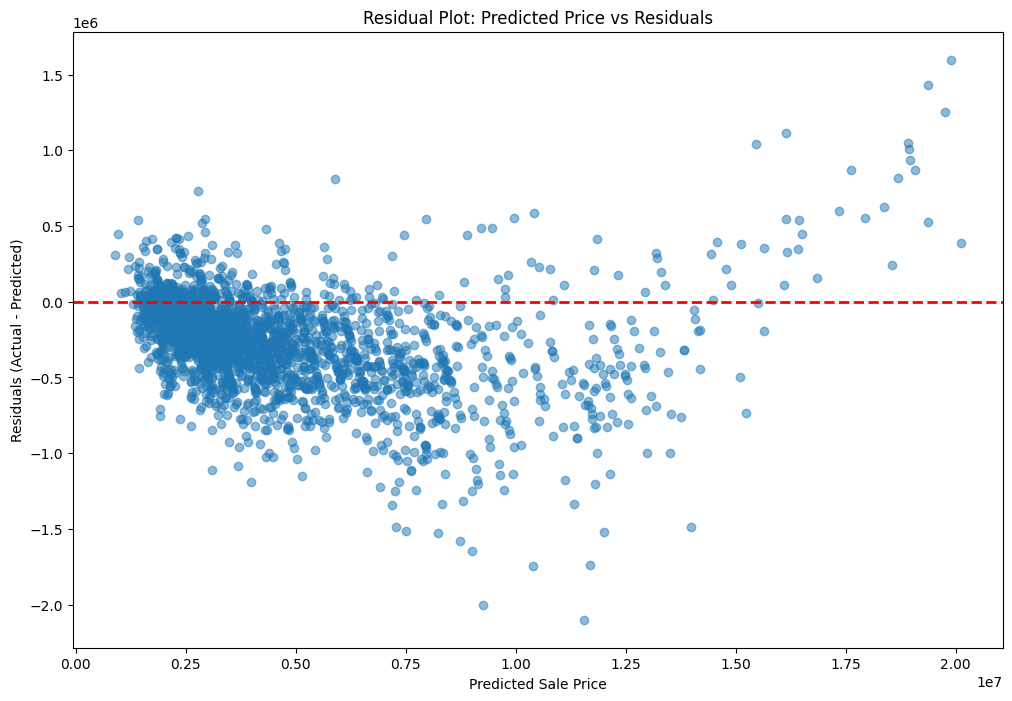

In [392]:
# Visualize Actual vs. Predicted Prices (All Data)
plt.figure(figsize=(12, 8))
plt.scatter(df_listings['listing_price'], df_listings['predicted_price'], alpha=0.5)
plt.plot(
    [df_listings['listing_price'].min(), df_listings['listing_price'].max()], 
    [df_listings['listing_price'].min(), df_listings['listing_price'].max()], 
    'r--', lw=2  # Line to indicate perfect predictions
)
plt.xlabel('Listing Price')
plt.ylabel('Predicted Sale Price')
plt.title('Listing Price vs Predicted Sale Price (Neural Network Model - All Data)')
plt.show()

# Remove infinite values for plotting
price_delta_clean_all = df_listings['price_delta'].replace([np.inf, -np.inf], np.nan).dropna()

# Visualize Distribution of Price Deltas (All Data)
plt.figure(figsize=(12, 6))
plt.hist(price_delta_clean_all, bins=50, edgecolor='black')
plt.title('Distribution of Price Deltas (All Data)')
plt.xlabel('Percentage Difference (%)')
plt.ylabel('Count')
plt.axvline(x=0, color='r', linestyle='--')
plt.show

# Calculate residuals
df_listings['residuals'] = df_listings['listing_price'] - df_listings['predicted_price']

# Plot residuals
plt.figure(figsize=(12, 8))
plt.scatter(df_listings['predicted_price'], df_listings['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: Predicted Price vs Residuals')
plt.show()

In [ ]:
# Use k-means to reduce background data for SHAP
background_kmeans = shap.kmeans(X_train_preprocessed, 10)  # Reduce to 10 representative samples

# Create the SHAP explainer with the reduced background using k-means
explainer = shap.KernelExplainer(nn_model.predict, background_kmeans)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val_preprocessed)

# Plot SHAP summary
shap.summary_plot(shap_values, X_val_preprocessed, feature_names=preprocessor.get_feature_names_out())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/831 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/s

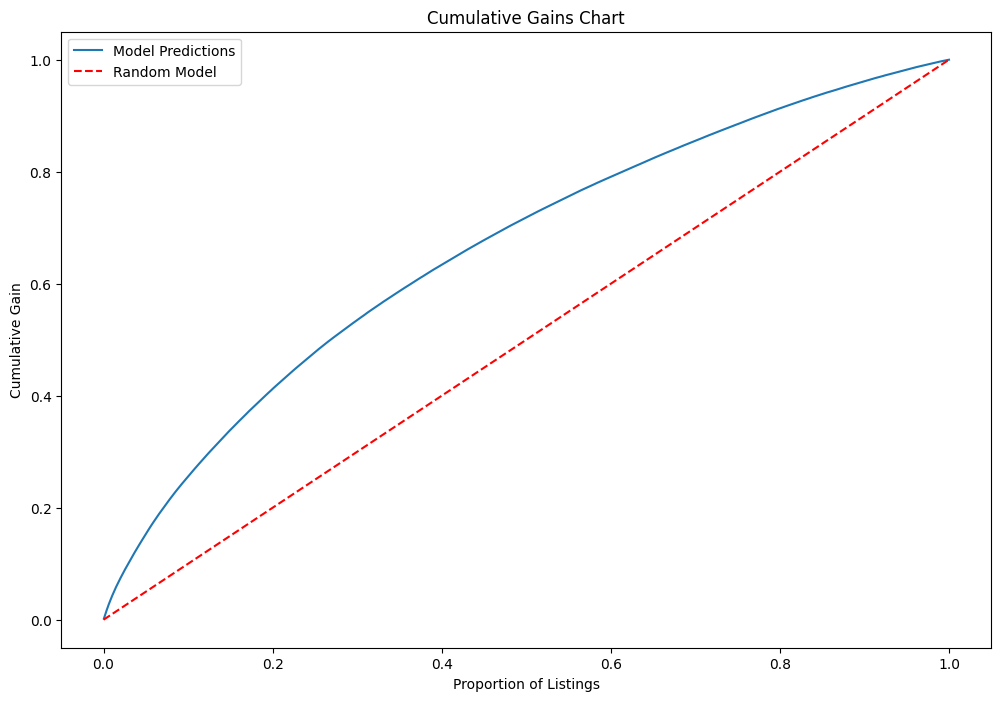

In [369]:
from sklearn.metrics import roc_curve

# Sort by predicted prices
df_listings_sorted = df_listings.sort_values('predicted_price', ascending=False)

# Create cumulative gain plot
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(df_listings_sorted)+1)/len(df_listings_sorted), np.cumsum(df_listings_sorted['listing_price']) / np.sum(df_listings_sorted['listing_price']), label='Model Predictions')
plt.plot([0,1], [0,1], 'r--', label='Random Model')
plt.xlabel('Proportion of Listings')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gains Chart')
plt.legend()
plt.show()

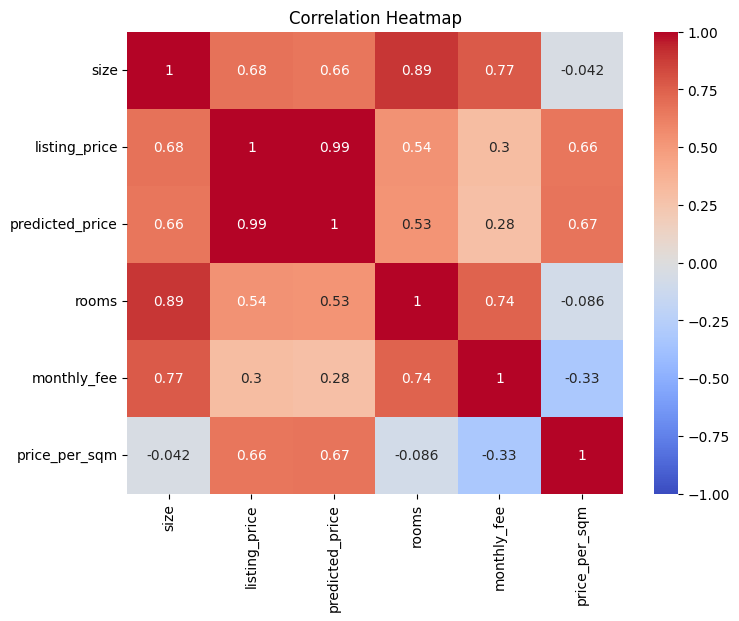

In [370]:
import seaborn as sns

# Create correlation matrix
corr_matrix = df_listings[['size', 'listing_price', 'predicted_price', 'rooms', 'monthly_fee', 'price_per_sqm']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [371]:
# Define the function to calculate price_delta
def calculate_price_delta(row):
    """
    Calculates the percentage difference between predicted sale price and listing price.
    """
    actual = row['listing_price']
    predicted = row['predicted_price']
    if actual == 0:  # To prevent division by zero
        return np.inf if predicted > 0 else -np.inf
    else:
        return (predicted - actual) / actual * 100

# Apply the price_delta calculation to the dataframe
df_listings['price_delta'] = df_listings.apply(calculate_price_delta, axis=1)

# Calculate the absolute price delta
df_listings['abs_price_delta'] = df_listings['price_delta'].abs()
pd.set_option('display.max_colwidth', None)
# Now print the dataframe with the required columns
df_listings[['link', 'size', 'date', 'listing_price', 'predicted_price', 'price_delta', 'abs_price_delta']].head()


link  \
0                             https://www.hemnet.se/bostad/lagenhet-4rum-vasastan-stockholms-kommun-gavlegatan-4,-2-1-2-tr-21408668   
1                      https://www.hemnet.se/bostad/lagenhet-1,5rum-gardet-ostermalm-stockholms-kommun-osthammarsgatan-70b-21410680   
3                                   https://www.hemnet.se/bostad/lagenhet-3rum-mariehall-stockholms-kommun-masugnsvagen-86-20548297   
4  https://www.hemnet.se/bostad/lagenhet-2rum-spanga-bromstensstaden-stockholms-kommun-akare-engstroms-vag-5,-2-tr-lgh-065-21274981   
5                                   https://www.hemnet.se/bostad/lagenhet-3rum-gardet-stockholms-kommun-sandhamnsgatan-75b-21286901   

   size                       date  listing_price  predicted_price  \
0  96.0 2024-08-19 11:26:14.718597       10500000      11271912.00   
1  35.0 2024-08-26 11:26:14.718597        3250000       3601259.25   
3  79.5 2024-09-01 11:26:14.718597        5795000       6040762.00   
4  43.0 2024-08-21 11:26:14.718597        2150000       2049933.00   
5  82.0 2024-09-07 11:26:14.718597        7395000       7525466.50   

   price_delta  abs_price_delta  
0     7.351543         7.351543  
1    10.807977        10.807977  
3     4.240932         4.240932  
4    -4.654279         4.654279  
5     1.764253         1.764253

In [376]:
# Step 0: Assuming the 'df_sold' dataset has been processed, and neighborhood price calculations are available
# We'll calculate average neighborhood prices from 'df_sold' to map them to the new data.
location_avg_price = df_sold.groupby('main_neighborhood')['price_per_sqm'].mean()
location_avg_price_sub = df_sold.groupby('sub_neighborhood')['price_per_sqm'].mean()

# Sample limited data (assuming you have this structure)
limited_data = pd.DataFrame({
    'link': ['https://example.com/listing/123'],
    'exact_address': ['Main Street 123, Stockholm'],
    'price': [5000000],  # listing price (this should be renamed to 'listing_price')
    'size': [80],  # size in sqm
    'rooms': [3],
    'floor': [2],
    'monthly_fee': [4000],
    'price_per_sqm': [5000000 / 80],  # listing price divided by size
    'location': ['södermalm, sofia, stockholms kommun'],
    'has_elevator': [1],
    'has_balcony': [1]
})

# Rename 'price' column to 'listing_price'
limited_data = limited_data.rename(columns={'price': 'listing_price'})

# Step 1: Parse the location
limited_data['main_neighborhood'], limited_data['sub_neighborhood'] = zip(*limited_data['location'].apply(parse_location_enhanced))

# Step 2: Map the pre-calculated neighborhood prices to the custom data
limited_data['location_avg_price_per_sqm'] = limited_data['main_neighborhood'].map(location_avg_price)
limited_data['location_avg_price_per_sqm_sub'] = limited_data['sub_neighborhood'].map(location_avg_price_sub)

# Fill missing values in case the neighborhood is not found in df_sold
limited_data['location_avg_price_per_sqm'].fillna(limited_data['price_per_sqm'].mean(), inplace=True)
limited_data['location_avg_price_per_sqm_sub'].fillna(limited_data['price_per_sqm'].mean(), inplace=True)

# Step 3: Add missing engineered features
limited_data['rooms_per_sqm'] = limited_data['rooms'] / limited_data['size']
limited_data['is_central'] = limited_data['location'].str.contains('centrum|centrala|city', case=False, na=False).astype(int)

# Calculate log transformations (to prevent issues with negative or zero values)
limited_data['log_size'] = np.log1p(limited_data['size'])
limited_data['log_price_per_sqm'] = np.log1p(limited_data['price_per_sqm'])
limited_data['log_monthly_fee'] = np.log1p(limited_data['monthly_fee'])

# Add date-related fields (if needed, you can use the current date)
current_date = datetime.now()
limited_data['year'] = current_date.year
limited_data['month'] = current_date.month
limited_data['season'] = current_date.month % 12 // 3 + 1
limited_data['months_since_sale'] = 0  # As this is a listing, you can set this to 0

# Step 4: Define features based on the same structure used during training
features = [
    'size', 'rooms', 'monthly_fee', 'has_elevator', 'has_balcony',
    'listing_price',  # Ensure 'listing_price' is included as a feature
    'rooms_per_sqm', 'is_central', 'location_avg_price_per_sqm', 'location_avg_price_per_sqm_sub',
    'year', 'month', 'season', 'main_neighborhood', 'sub_neighborhood', 'months_since_sale',
    'price_per_sqm', 'log_size', 'log_price_per_sqm', 'log_monthly_fee'
]

# Step 5: Preprocess the input using the preprocessor
limited_data_preprocessed = preprocessor.transform(limited_data[features])

# Step 6: Make predictions
limited_pred_scaled = nn_model.predict(limited_data_preprocessed).flatten()

# Step 7: Inverse scale the predictions to get the original scale
limited_pred = y_scaler.inverse_transform(limited_pred_scaled.reshape(-1, 1)).flatten()

# Output the prediction
print(f"Predicted sale price for the limited data input: {limited_pred[0]:,.2f} SEK")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted sale price for the limited data input: 4,309,288.50 SEK
